# Sentiment Analysis - Labelled Financial News Data Using Transformer Models


In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
import evaluate

### Loading the data

In [2]:
data = pd.read_csv('data/Fin_cleaned.csv', encoding='utf-8')

# duplicate the data
news = data.copy()

news

,Date_published,Headline,Synopsis,Full_text,Final Status
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,Negative
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,Positive
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,Positive
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,Negative
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,Positive
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",Negative
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,Negative
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,Negative
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,Positive


### Data Preprocessing

In [3]:
# Fill the missing value with an empty string
news['Synopsis'] = news['Synopsis'].fillna('')

# Rename columns
news = news.rename(
    columns={'Date_published': 'date', 'Headline': 'headline', 'Synopsis': 'synopsis', 'Full_text': 'text',
             'Final Status': 'label'})

# Remove the spaces from the labels
news['label'] = news['label'].str.strip()

# Convert labels to binary
news['label'] = news['label'].apply(lambda x: 1 if x == 'Positive' else 0)

news

,date,headline,synopsis,text,label
0,2022-06-21,"Banks holding on to subsidy share, say payment...",The companies have written to the National Pay...,ReutersPayments companies and banks are at log...,0
1,2022-04-19,Digitally ready Bank of Baroda aims to click o...,"At present, 50% of the bank's retail loans are...",AgenciesThe bank presently has 20 million acti...,1
2,2022-05-27,Karnataka attracted investment commitment of R...,Karnataka is at the forefront in attracting in...,PTIKarnataka Chief Minister Basavaraj Bommai.K...,1
3,2022-04-06,Splitting of provident fund accounts may be de...,The EPFO is likely to split accounts only at t...,Getty ImagesThe budget for FY22 had imposed in...,0
4,2022-06-14,Irdai weighs proposal to privatise Insurance I...,"Set up in 2009 as an advisory body, IIB collec...",AgenciesThere is a view in the insurance indus...,1
...,...,...,...,...,...
395,2022-06-10,"Banks take a cue from RBI, hike lending rates",These banks raised their respective external b...,"PTIICICI Bank, Bank of Baroda, Punjab National...",0
396,2022-06-29,Sebi issues Rs 27 lakh recovery notice to indi...,"In the event of non-payment, it will recover t...",ReutersThe logo of the Securities and Exchange...,0
397,2022-06-06,Apollo Hospital shares drop 0.68% as Sensex ...,"A total of 10,105 shares changed hands on the ...",Getty ImagesShrikant Chouhan of Kotak Securiti...,0
398,2022-05-16,SBI at Rs 710? What makes analysts see up to 5...,Calling the stock 'attractively valued' analys...,AgenciesThe PSU bank reported a 41.27 per cent...,1


## Create a dataset dictionary

In [4]:
# Create a dataset dictionary
dataset = Dataset.from_pandas(news)

# Display the dataset dictionary    
dataset

Dataset({
    features: ['date', 'headline', 'synopsis', 'text', 'label'],
    num_rows: 400
})

### Split the dataset into training and testing sets

In [5]:
# We will split the dataset into 80% training and 20% testing
train_test = dataset.train_test_split(test_size=0.2)

In [6]:
# Now we will split the test set into 50% validation and 50% test
valid_test = train_test['test'].train_test_split(test_size=0.5)

### Create a final dataset dictionary

In [7]:
# Combine the training, validation, and testing sets into a single dictionary
final_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

final_dataset

DatasetDict({
    train: Dataset({
        features: ['date', 'headline', 'synopsis', 'text', 'label'],
        num_rows: 320
    })
    validation: Dataset({
        features: ['date', 'headline', 'synopsis', 'text', 'label'],
        num_rows: 40
    })
    test: Dataset({
        features: ['date', 'headline', 'synopsis', 'text', 'label'],
        num_rows: 40
    })
})

## Dataset Tokenization

In [8]:
# Model name
model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Function to tokenize the dataset
def tokenize_function(examples, column):
    return tokenizer(examples[column], truncation=True, padding='max_length')

# list of text columns
text_columns = ['headline', 'synopsis', 'text']

# Tokenize the dataset
for column in text_columns:
    tokenized_datasets = final_dataset.map(lambda examples: tokenize_function(examples, column), batched=True)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

## Loading & Fine-tuning the model

This model is a distilled version of the RoBERTa-base model. It follows the same training procedure as DistilBERT.
The model has 6 layers, 768 dimension and 12 heads, totalizing 82M parameters (compared to 125M parameters for RoBERTa-base). On average DistilRoBERTa is twice as fast as Roberta-base.

In [9]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)

# Load the metric
metric = evaluate.load("accuracy")

huggingface_org = "NLP-FEUP/"
saving_dir = huggingface_org + model_name.replace("/", "-")

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./training_results/" + model_name.replace("/", "-"),
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=saving_dir,
)

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Define the function to compute the metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rnrib\miniconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batc

## Training the model

In [10]:
# Train the model
train = False
if train:
    trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.154011,0.975000
2,No log,0.332762,0.925000
3,No log,0.112278,0.975000
4,No log,0.384003,0.925000
5,No log,0.380687,0.925000


TrainOutput(global_step=200, training_loss=0.29832317352294924, metrics={'train_runtime': 1135.676, 'train_samples_per_second': 1.409, 'train_steps_per_second': 0.176, 'total_flos': 211947837849600.0, 'train_loss': 0.29832317352294924, 'epoch': 5.0})

In [11]:
# Evaluate the model
if train:
    trainer.evaluate()

In [12]:
# Save the model to the hub
if train:
    trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/NLP-FEUP/mrm8488-distilroberta-finetuned-financial-news-sentiment-analysis/commit/a45baf078e685f2c0eb1b65b5d412c2b88152902', commit_message='End of training', commit_description='', oid='a45baf078e685f2c0eb1b65b5d412c2b88152902', pr_url=None, pr_revision=None, pr_num=None)

## Loading trained model

In [15]:
# Load the tokenizer
tokenizer2 = AutoTokenizer.from_pretrained(saving_dir)

tokenizer_config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

In [22]:
# Load the model
model2 = AutoModelForSequenceClassification.from_pretrained(saving_dir, num_labels=2)

In [33]:
# Define the trainer
trainer2 = Trainer(
    model=model2,
    tokenizer=tokenizer2,
    compute_metrics=compute_metrics,
)

c:\Users\rnrib\miniconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


## Evaluate the model

In [85]:
# Predict the test set
predictions = trainer2.predict(tokenized_datasets['test'])

In [86]:
# Display the predictions
predictions

PredictionOutput(predictions=array([[-2.7537951 ,  2.6960702 ],
       [ 2.2564902 , -2.1782851 ],
       [-2.8149562 ,  2.7001128 ],
       [ 2.2929924 , -2.1992598 ],
       [-2.8455863 ,  2.7175598 ],
       [-1.6792735 ,  1.8585746 ],
       [-2.8531985 ,  2.6728404 ],
       [-2.814076  ,  2.724172  ],
       [-2.822641  ,  2.6718454 ],
       [-2.404652  ,  2.2511811 ],
       [ 2.3376155 , -2.2045958 ],
       [ 2.1888137 , -2.153772  ],
       [-2.8433394 ,  2.7760806 ],
       [-2.7414896 ,  2.6671982 ],
       [ 2.178466  , -2.191671  ],
       [-2.7624226 ,  2.695127  ],
       [ 2.1937864 , -2.129368  ],
       [-2.6260257 ,  2.6524892 ],
       [-2.7739453 ,  2.735312  ],
       [ 2.3074732 , -2.242183  ],
       [-0.9572915 ,  1.0490335 ],
       [ 1.913923  , -2.0471148 ],
       [-2.7796946 ,  2.7153187 ],
       [-2.8078856 ,  2.6855316 ],
       [ 2.2476976 , -2.1765935 ],
       [-2.644794  ,  2.5610828 ],
       [-2.9069161 ,  2.6777687 ],
       [-2.7884865 ,  2.69

### Compute relevant metrics

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Get the predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Get the true labels
true_labels = predictions.label_ids

# Compute the confusion matrix
confusion_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute the precision
precision = precision_score(true_labels, predicted_labels)

# Compute the recall
recall = recall_score(true_labels, predicted_labels)

# Compute the F1 score
f1 = f1_score(true_labels, predicted_labels)

In [88]:
# Save the results to a dataframe
results_transformer = pd.DataFrame([{
    'Model': 'Transformer',
    'Feature Representation': 'N/A',
    'Columns': 'text',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
}])

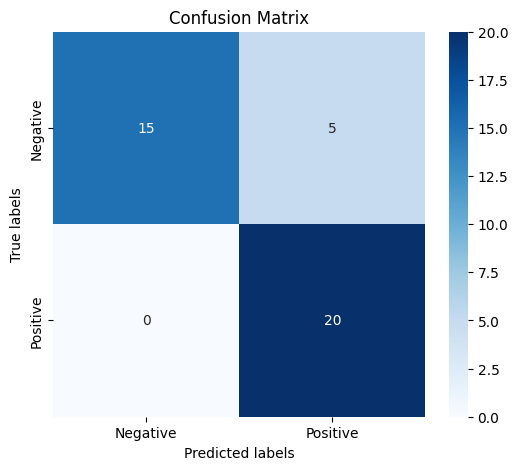

In [89]:
# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels
labels = ['Negative', 'Positive']

# Create the confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Load results from previous assignment

In [94]:
# Load the results from the previous assignment to a list of dictionaries
previous_results = pd.read_csv('results/assignment1_comparison.csv')

# Display the previous results
previous_results

,Model,Columns,Feature Representation,F1-score,Accuracy,Precision,Recall
0,VADER,combined_text,NaN,0.723549,0.595,0.572973,0.981481
1,Multi-Layer Perceptron,"headline_embeddings, synopsis_embeddings",Word2Vec FinText AI,0.751323,0.755,0.758598,0.751341
2,Loughran-McDonald,combined_text,NaN,0.734545,0.635,0.604790,0.935185


In [98]:
# Concatenate the results
results = pd.concat([previous_results.copy(), results_transformer], ignore_index=True)

# Save the results to a CSV file
results.to_csv('results/assignment2_comparison.csv', index=False)

# Sort the results by f1-score
results = results.sort_values(by='F1-score', ascending=False)

results

,Model,Columns,Feature Representation,F1-score,Accuracy,Precision,Recall
3,Transformer,text,N/A,0.888889,0.875,0.800000,1.000000
1,Multi-Layer Perceptron,"headline_embeddings, synopsis_embeddings",Word2Vec FinText AI,0.751323,0.755,0.758598,0.751341
2,Loughran-McDonald,combined_text,NaN,0.734545,0.635,0.604790,0.935185
0,VADER,combined_text,NaN,0.723549,0.595,0.572973,0.981481


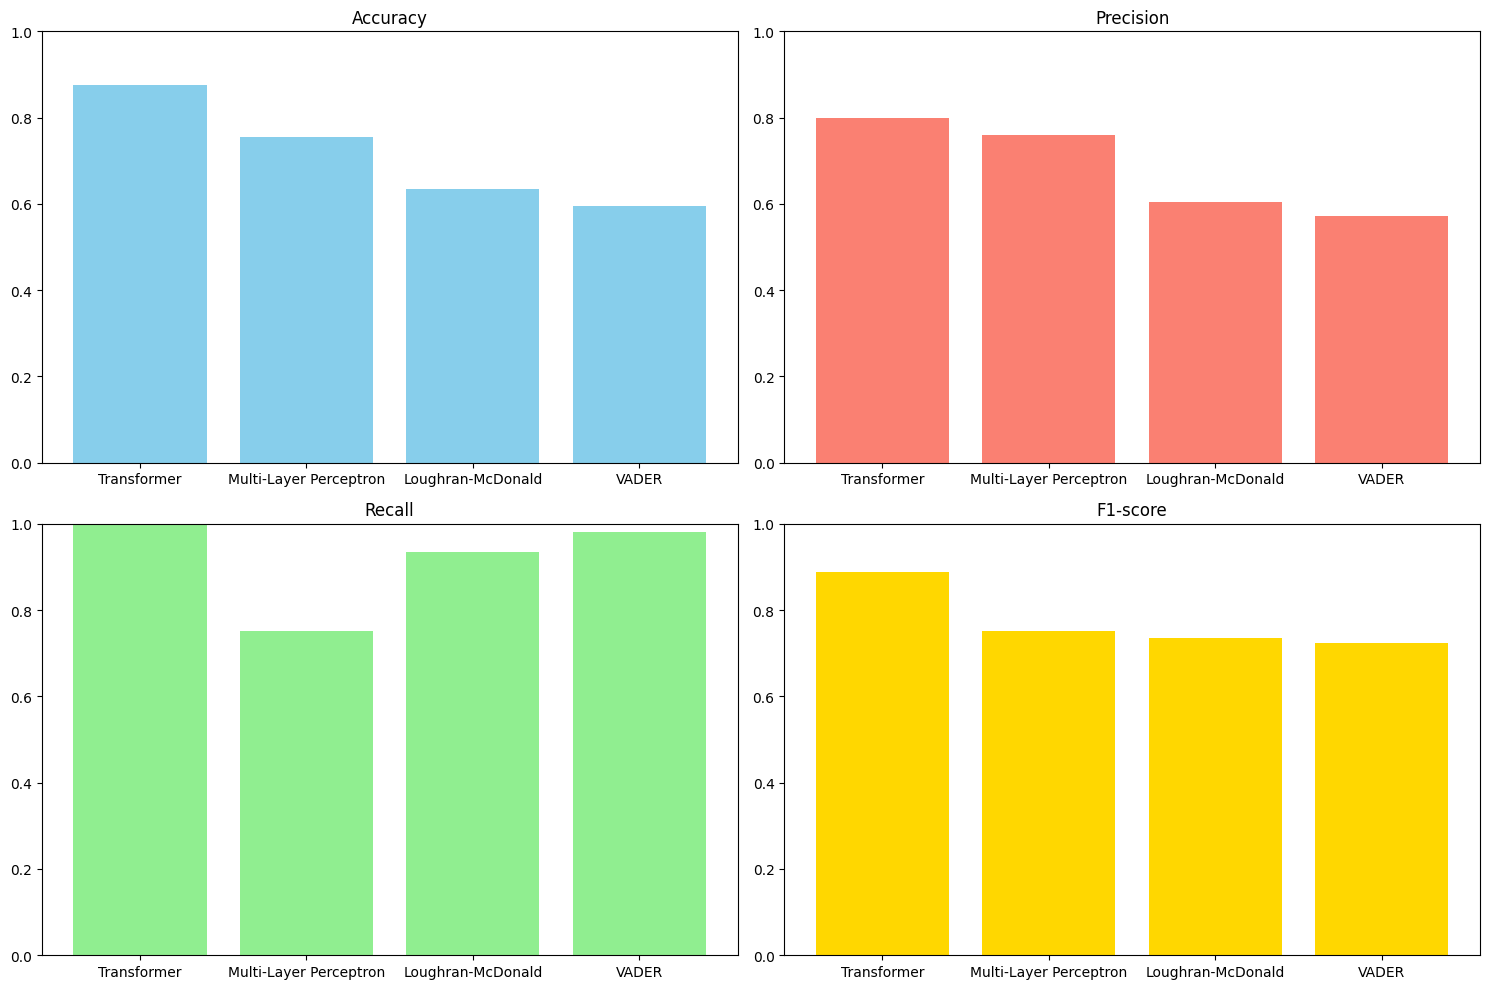

In [100]:
# Plot the results
import matplotlib.pyplot as plt

# Define the figure and the axes
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the accuracy
ax[0, 0].bar(results['Model'], results['Accuracy'], color='skyblue')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim(0, 1)

# Plot the precision
ax[0, 1].bar(results['Model'], results['Precision'], color='salmon')
ax[0, 1].set_title('Precision')
ax[0, 1].set_ylim(0, 1)

# Plot the recall
ax[1, 0].bar(results['Model'], results['Recall'], color='lightgreen')
ax[1, 0].set_title('Recall')
ax[1, 0].set_ylim(0, 1)

# Plot the f1-score
ax[1, 1].bar(results['Model'], results['F1-score'], color='gold')
ax[1, 1].set_title('F1-score')
ax[1, 1].set_ylim(0, 1)

# Display the plot
plt.tight_layout()
plt.show()